# Курсовая работа № 2
## Аналитика. Начальный уровень

Курсовая работа состоит из двух частей – обязательной и дополнительной. **Для зачета необходимо выполнение только первой части.** Выполнение второй части может потребовать дополнительные знания Python.

- [Часть первая](#Часть-первая)
- [Часть вторая](#Часть-вторая)

## Часть первая


Перед вами стоит задача – подготовить аналитический отчет для HR-отдела. На основании проведенной аналитики предполагается составить рекомендации для отдела кадров по стратегии набора персонала, а также по взаимодействию с уже имеющимися сотрудниками.
<br><br> В базе данных лежит набор таблиц, которые содержат данные о сотрудниках вымышленной компании.
Сделайте обзор штата сотрудников компании. Составьте набор предметов исследования, а затем проверьте их на данных. Вся аналитика должна быть выполена с помощью SQL. Впоследствии данные можно визуализировать, однако финальные датафреймы для графиков также должны быть подготовлены с помощью SQL. <br><br>

Примеры гипотез:
1. Есть зависимость между `perfomance score` и тем, под чьим руководством работает сотрудник.
2. Есть зависимость между продолжительностью работы в компании и семейным положением сотрудника.
2. Есть зависимость между продолжительностью работы в компании и возрастом сотрудника.

<br><br>
Параметры для подключения следующие: хост – `dsstudents.skillbox.ru`, порт – `5432`, имя базы данных – `human_resources`, пользователь – `readonly`, пароль – `6hajV34RTQfmxhS`. Таблицы, доступные для анализа, – `hr_dataset`, `production_staff`, `recruting_costs`, `salary_grid`.

In [1]:
import psycopg2
import pandas as pd
import sqlite3

pg_connection = {
    "host": "dsstudents.skillbox.ru",
    "port": 5432,
    "dbname": "human_resources",
    "user": "readonly",
    "password": "6hajV34RTQfmxhS"
}

conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()
sql_string_test = "SELECT table_name FROM information_schema.tables  WHERE table_schema='public';"

cursor.execute(sql_string_test)
name_table = cursor.fetchall()
name_table = [a[0] for a in name_table]
print(cursor.description)
conn.close()

(Column(name='table_name', type_code=1043),)


In [2]:
name_table
# Данные о названии таблиц в базе получены

['hr_dataset',
 'production_staff',
 'male',
 'female',
 'recruiting_costs',
 'hr_dataset_view',
 'numb_of_hire',
 'numb_of_terms',
 'salary_grid',
 'days_work',
 'show_functions',
 'abu_pay',
 'abupay1',
 'share_employee_source',
 'tmpDB',
 'mmm',
 'abupay']

In [3]:
def chisqlite():
    'Позволяет просматривать таблицы в Postgresql'
    conn = psycopg2.connect(**pg_connection)
    cursor = conn.cursor()
    print(sorted(name_table))
    chosen_table = input('Выберите таблицу из вышепредставленных:')
    index_table = name_table.index(chosen_table)
    sql_string = "SELECT column_name, data_type FROM INFORMATION_SCHEMA.COLUMNS WHERE table_name =  '{}' ;".format(name_table[index_table])
    cursor.execute(sql_string)
    columns = cursor.fetchall()
    column_names = [a for a, b in columns]
    print('Названия колонок в выбранной таблице: {}'.format(sorted(column_names)))
    selector = input('SELECT {ваш ввод} (по умолчанию *)')
    if len(selector) == 0:
        selector = '*'
    where = input('Введите условие WHERE {ваш ввод} (по умолчанию отсутствует)')
    if len(where) > 0:
        where = 'WHERE {}'.format(where)
    grouper = input('Введите GROUP BY {ваш ввод} (по умолчанию отсутствует)')
    if len(grouper) > 0:
        grouper = 'GROUP BY {}'.format(grouper)
    order = input('Введите ORDER BY {ваш ввод} (по умолчанию отсутствует)')
    if len(order) > 0:
        order = 'ORDER BY {}'.format(order)
    sql_string = 'SELECT {cols} FROM {name_table} {where} {grouper} {order};'.format(cols = selector, name_table = name_table[index_table], where = where, order = order, grouper = grouper)
    cursor.execute(sql_string)
    res = cursor.fetchall()

    conn.close()

    try:
        res_df = pd.DataFrame(res, columns = column_names)
    except:
        if selector != '*':
            res_df = pd.DataFrame(res, columns = selector.split(', '))
        else:
            res_df = pd.DataFrame(res)
    return res_df

In [4]:
def chisql(pg_connection = pg_connection):
    'Позволяет реализовывать команды PostgreSQL и сохранять результаты'
    progress_counter = 0 # Позволяет отлавливать ошибки
    # Описания ошибок, сейчас не нужно errors_descr = ["Не удалось подключится к базе данных", "Неправильное имя таблицы / пустой запрос", "Неверный/Пустой запрос SQL"]
    dct1 = {}
    dct2 = {}
    tables = []
    #try: - Отлов ошибок, сейчас не нужен
    conn = psycopg2.connect(**pg_connection)
    progress_counter += 1
    cursor = conn.cursor()
    sql_string = "SELECT table_name FROM information_schema.tables  WHERE table_schema='public';"
    cursor.execute(sql_string)
    name_table = cursor.fetchall()
    name_table = [a[0] for a in name_table]
    print('Таблицы, в указанной базе данных:')
    print(', '.join(sorted(name_table)))
    print(' ')
    checker = False
    chosen_table1 = input('Выберите таблицу из вышепредставленных: ')
    tables.append(chosen_table1)
    while checker == False:
        chosen_table2 = input('Выберите еще таблицу из вышепредставленных или наберите continue:')
        if chosen_table2 == 'continue':
            checker = 1
        else:
            tables.append(chosen_table2)
    print(' ')
    # Выбраны таблицы для работы, функция возьмет для них информацию о столбцах

    column_counter = {}
    for table in tables:
        index_table = name_table.index(table)
        sql_string = "SELECT column_name, data_type FROM INFORMATION_SCHEMA.COLUMNS WHERE table_name =  '{}' ;".format(name_table[index_table])
        cursor.execute(sql_string)
        columns = cursor.fetchall()
        column_names = [a for a, b in columns]
        for a in column_names:
            if a not in column_counter:
                column_counter[a] = [table]
            else:
                column_counter[a].append(table)
        print('Названия колонок в таблице {} : '.format(table))
        print(', '.join(sorted(column_names)))
    print(' ')
    # Функция забрала информацию о столбцах, выводится только имя, все остальное в columns

    special_columns = [] 
    for key in column_counter:
        if len(column_counter[key]) > 1:
            pre_term = ["'" +  a + "'" for a in column_counter[key]]
            term = ' OR information_schema.key_column_usage.table_name = '.join(pre_term)
            sql_string = """SELECT table_name, column_name, constraint_name 
                                 FROM information_schema.key_column_usage 
                                 WHERE information_schema.key_column_usage.table_name = {term}""".format(term = term)
            cursor.execute(sql_string)
            special_columns.extend(cursor.fetchall())
    # Получает информацию о стобцах которые встречаются в выбранных таблицах больше 1 раза
    # Это нужно чтобы проверить, являются ли они ключевыми

    special_columns = list(set(special_columns))
    sql_string = "SELECT constraint_name, unique_constraint_name FROM information_schema.referential_constraints"
    cursor.execute(sql_string)
    keys_of_database = cursor.fetchall()
    # Получает информацию о всех ключах в датабазе, их названиях для разных таблиц
    
    matches = {}
    for x in special_columns:
        for y in keys_of_database:
            if x[2] in y:
                if matches.get(y) == None:
                    matches[y] = [x]    
                else:
                    matches[y].append(x)
    matches = [a for a in matches.values() if len(a) > 1]
    # Поскольку PostgreSQL очень хитро сохраняет свои ключи это, как мне кажется, самый простой способ
    # (А без стороннего ПО так вообще единственный) для получения информации о том кто кому приходится В PostgreSQL

    if len(matches) > 0:
        print('Кажется, следующие таблицы связаны:')
    for i in range(len(matches)):
        names_table = []
        names_columns = []
        for x in matches[i]:
            names_table.append(x[0])
            names_columns.append(x[1])
        names_table = ', '.join(set(names_table))
        names_columns = ', '.join(set(names_columns))
        print(names_table + ' по колонкам ' + names_columns)
    print(' ')
    progress_counter += 1
    # На данном этапе еще не написана основная команда, но пользователь видит прямо перед глазами основную информацию
    # О выбранных таблицах и ключевых столбцах, что позволит сэкономить просто кучу времени

    checker = False
    while checker == False:
        sql_string = input('Введите желаемое действие:')
        cursor.execute(sql_string)
        save = input('Хотите ли сохранить полученные значения? Введите y если да ')
        if save == 'y':
            save_name = input('Введите имя для сохранения: ')
            dct1[save_name] = cursor.fetchall()
            dct2[save_name] = [column[0] for column in cursor.description]
        check = input('Желаете продолжить? Введите y если да ')
        # *Продолжить вбивать другие команды, не сохранив не получится увидеть полученный датафрейм
        if check != 'y':
            checker = 1
    print(' ')
    progress_counter += 1
    #except:
        #conn.close()
        #print(errors_desc[progress_counter]) - Отлов ошибок в самой функции, на данный момент не нужно не нужно
    conn.close()
    # Результаты с сервера получены, далее формируются датафреймы в удобном виде и есть возможность проверить их количество
    
    
    dct = {}
    for keys in dct1:
        df = pd.DataFrame(dct1[keys], columns = dct2[keys])
        dct[keys] = df
    # Предшественник этой функции имел изъяны связанные с отображением названий столбцов, данные и их названия в этой функции
    # Сохраняются в разных словарях, здесь они соединяются, поэтому невозможно просмотреть несохраненный датафрейм
    
    saved_data = [x for x, y in dct.items()]
    print('Сохраненные данные :')
    print(', '.join(saved_data))
    print(' ')
    #Высвечивает названия сохранений
    quest = input('Желаете просмотреть сохраненные данные? Введите y если да') # print и df плохо ладят, некрасиво выводит результат
    if quest == 'y':
        print('Чтобы просмотреть результат введите имя сохранения')
        print(' ')
        checker = False
        while checker == False:
            chosen_save = input()
            print(dct[chosen_save])
            check = input('Хотите просмотреть другие сохранения? Введите y если да')
            if check != 'y':
                checker = 1
    return dct

Согласно условиям задания для выполнения курсовой необходимо проанализировать следуюшие таблицы: hr_dataset, production_staff, recruting_costs, salary_grid.  
   # Рассмотрим таблицы, предложенные для анализа

In [5]:
save1 = chisql()

Таблицы, в указанной базе данных:
abu_pay, abupay, abupay1, days_work, female, hr_dataset, hr_dataset_view, male, mmm, numb_of_hire, numb_of_terms, production_staff, recruiting_costs, salary_grid, share_employee_source, show_functions, tmpDB
 


Выберите таблицу из вышепредставленных:  hr_dataset
Выберите еще таблицу из вышепредставленных или наберите continue: recruiting_costs
Выберите еще таблицу из вышепредставленных или наберите continue: production_staff
Выберите еще таблицу из вышепредставленных или наберите continue: salary_grid
Выберите еще таблицу из вышепредставленных или наберите continue: continue


 
Названия колонок в таблице hr_dataset : 
Date of Hire, Date of Termination, Days Employed, Employee Name, Employee Number, Employee Source, Employment Status, Hispanic/Latino, Manager Name, Pay Rate, Performance Score, Reason For Term, age, citizendesc, department, deptid, dob, empstatus_id, genderid, id, maritaldesc, maritalstatusid, marriedid, perf_scoreid, position, racedesc, sex, state, zip
Названия колонок в таблице recruiting_costs : 
April, August, December, Employment Source, February, January , July, June, March, May, November, October, September, Total, id
Названия колонок в таблице production_staff : 
90-day Complaints, Abutments/Hour Wk 1, Abutments/Hour Wk 2, Daily Error Rate, Date of Hire, Department, Employee Name, Employment Status, Manager Name, Pay, Performance Score, Position, Race Desc, Reason for Term, TermDate, id
Названия колонок в таблице salary_grid : 
Hourly Max, Hourly Mid, Hourly Min, Position, Salary Max, Salary Mid, Salary Min, id
 
 


Введите желаемое действие: SELECT * FROM hr_dataset
Хотите ли сохранить полученные значения? Введите y если да  y
Введите имя для сохранения:  hr_dataset
Желаете продолжить? Введите y если да  y
Введите желаемое действие: SELECT * FROM recruiting_costs
Хотите ли сохранить полученные значения? Введите y если да  y
Введите имя для сохранения:  recruiting_costs
Желаете продолжить? Введите y если да  y
Введите желаемое действие: SELECT * FROM production_staff
Хотите ли сохранить полученные значения? Введите y если да  y
Введите имя для сохранения:  production_staff
Желаете продолжить? Введите y если да  y
Введите желаемое действие: SELECT * FROM salary_grid
Хотите ли сохранить полученные значения? Введите y если да  y
Введите имя для сохранения:  salary_grid
Желаете продолжить? Введите y если да  n


 
Сохраненные данные :
hr_dataset, recruiting_costs, production_staff, salary_grid
 


Желаете просмотреть сохраненные данные? Введите y если да n


In [53]:
save1['hr_dataset']
# Вот так выглядит таблица hr_dataset

,id,Employee Name,Employee Number,marriedid,maritalstatusid,genderid,empstatus_id,deptid,perf_scoreid,age,...,Date of Hire,Days Employed,Date of Termination,Reason For Term,Employment Status,department,position,Manager Name,Employee Source,Performance Score
0,1,"Brown, Mia",1103024456,1,1,0,1,1,3,30,...,2008-10-27,3317,None,N/A - still employed,Active,Admin Offices,Accountant I,Brandon R. LeBlanc,Diversity Job Fair,Fully Meets
1,2,"LaRotonda, William",1106026572,0,2,1,1,1,3,34,...,2014-01-06,1420,None,N/A - still employed,Active,Admin Offices,Accountant I,Brandon R. LeBlanc,Website Banner Ads,Fully Meets
2,3,"Steans, Tyrone",1302053333,0,0,1,1,1,3,31,...,2014-09-29,1154,None,N/A - still employed,Active,Admin Offices,Accountant I,Brandon R. LeBlanc,Internet Search,Fully Meets
3,4,"Howard, Estelle",1211050782,1,1,0,1,1,9,32,...,2015-02-16,58,2015-04-15,N/A - still employed,Active,Admin Offices,Administrative Assistant,Brandon R. LeBlanc,Pay Per Click - Google,N/A- too early to review
4,5,"Singh, Nan",1307059817,0,0,0,1,1,9,30,...,2015-05-01,940,None,N/A - still employed,Active,Admin Offices,Administrative Assistant,Brandon R. LeBlanc,Website Banner Ads,N/A- too early to review
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,306,"Navathe, Kurt",1009919960,0,0,1,1,3,3,48,...,2017-02-10,289,None,N/A - still employed,Active,IT/IS,Senior BI Developer,Brian Champaigne,Indeed,Fully Meets
306,307,"Wang, Charlie",1009919970,0,0,1,1,3,3,36,...,2017-02-15,284,None,N/A - still employed,Active,IT/IS,Senior BI Developer,Brian Champaigne,Indeed,Fully Meets
307,308,"Smith, Jason",1009919980,0,0,1,1,3,3,34,...,2017-02-15,284,None,N/A - still employed,Active,IT/IS,BI Developer,Brian Champaigne,Indeed,Fully Meets
308,309,"Westinghouse, Matthew",1009919990,1,1,1,1,3,3,30,...,2017-04-20,220,None,N/A - still employed,Active,IT/IS,BI Developer,Brian Champaigne,Indeed,Fully Meets


In [7]:
save1['recruiting_costs']
# Вот так выглядит таблица recruiting_costs

,id,Employment Source,January,February,March,April,May,June,July,August,September,October,November,December,Total
0,1,Billboard,520,520,520,520,0,0,612,612,729,749,910,500,6192
1,2,Careerbuilder,410,410,410,820,820,410,410,820,820,1230,820,410,7790
2,3,Company Intranet - Partner,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,Diversity Job Fair,0,5129,0,0,0,0,0,4892,0,0,0,0,10021
4,5,Employee Referral,0,0,0,0,0,0,0,0,0,0,0,0,0
5,6,Glassdoor,0,0,0,0,0,0,0,0,0,0,0,0,0
6,7,Information Session,0,0,0,0,0,0,0,0,0,0,0,0,0
7,8,Internet Search,0,0,0,0,0,0,0,0,0,0,0,0,0
8,9,MBTA ads,640,640,640,640,640,640,640,1300,1300,1300,1300,1300,10980
9,10,Monster.com,500,500,500,440,500,500,440,500,440,440,500,500,5760


In [8]:
save1['salary_grid']
# Вот так выглядит таблица salary_grid

,id,Position,Salary Min,Salary Mid,Salary Max,Hourly Min,Hourly Mid,Hourly Max
0,1,Administrative Assistant,30000,40000,50000,14.42,19.23,24.04
1,2,Sr. Administrative Assistant,35000,45000,55000,16.83,21.63,26.44
2,3,Accountant I,42274,51425,62299,20.32,24.72,29.95
3,4,Accountant II,50490,62158,74658,24.27,29.88,35.89
4,5,Sr. Accountant,63264,76988,92454,30.42,37.01,44.45
5,6,Network Engineer,50845,66850,88279,24.44,32.14,42.44
6,7,Sr. Network Engineer,79428,99458,120451,38.19,47.82,57.91
7,8,Database Administrator,50569,68306,93312,24.31,32.84,44.86
8,9,Sr. DBA,92863,116007,139170,44.65,55.77,66.91
9,10,Production Technician I,30000,40000,50000,14.42,19.23,24.04


In [67]:
save1['production_staff']
# Вот так выглядит таблица production_staff

,id,Employee Name,Race Desc,Date of Hire,TermDate,Reason for Term,Employment Status,Department,Position,Pay,Manager Name,Performance Score,Abutments/Hour Wk 1,Abutments/Hour Wk 2,Daily Error Rate,90-day Complaints
0,1,"Albert, Michael",White,2011-08-01,None,N/A - still employed,Active,Production,Production Manager,$54.50,Elisa Bramante,Fully Meets,0.0,0.0,0.0,0.0
1,2,"Bozzi, Charles",Asian,2013-09-30,2014-08-07,retiring,Voluntarily Terminated,Production,Production Manager,$50.50,Elisa Bramante,Fully Meets,0.0,0.0,0.0,0.0
2,3,"Butler, Webster L",White,2016-01-28,None,N/A - still employed,Active,Production,Production Manager,$55.00,Elisa Bramante,Exceeds,0.0,0.0,0.0,0.0
3,4,"Dunn, Amy",White,2014-09-18,None,N/A - still employed,Active,Production,Production Manager,$51.00,Elisa Bramante,Fully Meets,0.0,0.0,0.0,0.0
4,5,"Gray, Elijiah",White,2015-06-02,None,N/A - still employed,Active,Production,Production Manager,$54.00,Elisa Bramante,Fully Meets,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,252,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN
252,253,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN
253,254,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN
254,255,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN


# Рассмотрим содержимое таблиц и их взаимосвязь

Если бы таблицы были связаны между собой в базе данных, функция бы написала об этом, что было протестировано на учебной базе dvdrental  
   (В предложенной же для анализа просто не прописаны ключи между таблицами)  
   Но у них у всех есть общий id  
   По условиям задания я не могу анализировать их в pandas  
   Поэтому сначала рассмотрю их содержимое  
   Очевидно, что salary_grid и recruiting_costs имеют специфические столбцы, не относящиеся к отдельным субъектам  
   Так, salary_grid говорит о зарплатах для разных групп работников  
   Тогда как recruiting_costs статистику по найму из разных источников  
   Эти 2 таблицы не перекрываются  
   Интереснее с hr_dataset и production_staff  
   И там и там есть имена и похожие колонки  
   Проверим, одни и те же ли это имена  

In [14]:
test1 = chisql()

Таблицы, в указанной базе данных:
abu_pay, abupay, abupay1, days_work, female, hr_dataset, hr_dataset_view, male, mmm, numb_of_hire, numb_of_terms, production_staff, recruiting_costs, salary_grid, share_employee_source, show_functions, tmpDB
 


Выберите таблицу из вышепредставленных:  hr_dataset
Выберите еще таблицу из вышепредставленных или наберите continue: production_staff
Выберите еще таблицу из вышепредставленных или наберите continue: continue


 
Названия колонок в таблице hr_dataset : 
Date of Hire, Date of Termination, Days Employed, Employee Name, Employee Number, Employee Source, Employment Status, Hispanic/Latino, Manager Name, Pay Rate, Performance Score, Reason For Term, age, citizendesc, department, deptid, dob, empstatus_id, genderid, id, maritaldesc, maritalstatusid, marriedid, perf_scoreid, position, racedesc, sex, state, zip
Названия колонок в таблице production_staff : 
90-day Complaints, Abutments/Hour Wk 1, Abutments/Hour Wk 2, Daily Error Rate, Date of Hire, Department, Employee Name, Employment Status, Manager Name, Pay, Performance Score, Position, Race Desc, Reason for Term, TermDate, id
 
 


Введите желаемое действие: SELECT * FROM hr_dataset JOIN production_staff ON hr_dataset."Employee Name" = production_staff."Employee Name"
Хотите ли сохранить полученные значения? Введите y если да  y
Введите имя для сохранения:  test
Желаете продолжить? Введите y если да  n


 
Сохраненные данные :
test
 


Желаете просмотреть сохраненные данные? Введите y если да n


In [29]:
test1['test']

,id,Employee Name,Employee Number,marriedid,maritalstatusid,genderid,empstatus_id,deptid,perf_scoreid,age,...,Employment Status,Department,Position,Pay,Manager Name,Performance Score,Abutments/Hour Wk 1,Abutments/Hour Wk 2,Daily Error Rate,90-day Complaints
0,11,"King, Janet",1001495124,1,1,0,1,2,3,63,...,Active,Production,Production Technician I,$23.00,Elijiah Gray,Fully Meets,9.0,10.0,1.0,1.0
1,54,"Albert, Michael",1501072311,0,2,1,1,5,3,49,...,Active,Production,Production Manager,$54.50,Elisa Bramante,Fully Meets,0.0,0.0,0.0,0.0
2,55,"Bozzi, Charles",1303054580,0,0,1,5,5,3,48,...,Voluntarily Terminated,Production,Production Manager,$50.50,Elisa Bramante,Fully Meets,0.0,0.0,0.0,0.0
3,56,"Butler, Webster L",1110029990,0,0,1,1,5,4,34,...,Active,Production,Production Manager,$55.00,Elisa Bramante,Exceeds,0.0,0.0,0.0,0.0
4,57,"Dunn, Amy",1409070147,0,0,0,1,5,3,44,...,Active,Production,Production Manager,$51.00,Elisa Bramante,Fully Meets,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,257,"Walker, Roger",1011022818,0,0,1,1,5,3,42,...,Active,Production,Production Technician II,$22.00,Ketsia Liebig,Fully Meets,18.0,17.0,0.0,0.0
204,258,"Winthrop, Jordan",1405067188,0,0,1,5,5,4,59,...,Voluntarily Terminated,Production,Production Technician II,$29.00,Brannon Miller,Exceeds,12.0,11.0,0.0,0.0
205,259,"Wolk, Hang T",1205033180,0,0,0,1,5,3,33,...,Active,Production,Production Technician II,$22.00,David Stanley,Fully Meets,12.0,17.0,0.0,0.0
206,260,"Woodson, Jason",1012023010,0,0,1,1,5,3,33,...,Active,Production,Production Technician II,$24.25,Kissy Sullivan,Fully Meets,NaN,NaN,NaN,NaN


# Информация в таблицах hr_dataset и production_staff

Да, действительно, у них есть пересечения друг с другом, но production_staff неполна

Информацию о чем они содержат?  
   Рассмотрим hr_dataset
   Его название говорит нам о том, что он как то связан с human resourses  
   Предположу что это таблица по всем сотрудникам для данного отдела  
   Содержание таблицы подтверждает мою гипотезу  
   Рассмотрим production_staff  
   Его название может быть проинтерпретировано по-разному  
   Предположу, что в нем есть лишь работники отдела Production  

In [34]:
test2 = chisql()

Таблицы, в указанной базе данных:
abu_pay, abupay, abupay1, days_work, female, hr_dataset, hr_dataset_view, male, mmm, numb_of_hire, numb_of_terms, production_staff, recruiting_costs, salary_grid, share_employee_source, show_functions, tmpDB
 


Выберите таблицу из вышепредставленных:  production_staff
Выберите еще таблицу из вышепредставленных или наберите continue: continue


 
Названия колонок в таблице production_staff : 
90-day Complaints, Abutments/Hour Wk 1, Abutments/Hour Wk 2, Daily Error Rate, Date of Hire, Department, Employee Name, Employment Status, Manager Name, Pay, Performance Score, Position, Race Desc, Reason for Term, TermDate, id
 
 


Введите желаемое действие: SELECT DISTINCT(production_staff."Department") FROM production_staff
Хотите ли сохранить полученные значения? Введите y если да  y
Введите имя для сохранения:  test
Желаете продолжить? Введите y если да  n


 
Сохраненные данные :
test
 


Желаете просмотреть сохраненные данные? Введите y если да n


In [35]:
test2['test']

,Department
0,None
1,Production


# Проверка на наличие аномалий в hr_dataset и production_staff

Действительно, production_staff содержит информацию только о сотрудниках отдела Production  
   Посмотрим, может ли человек быть прикрепленным сразу к нескольким отделам

In [41]:
test3 = chisql()
# Первый тест, проверка гипотезы

Таблицы, в указанной базе данных:
abu_pay, abupay, abupay1, days_work, female, hr_dataset, hr_dataset_view, male, mmm, numb_of_hire, numb_of_terms, production_staff, recruiting_costs, salary_grid, share_employee_source, show_functions, tmpDB
 


Выберите таблицу из вышепредставленных:  hr_dataset
Выберите еще таблицу из вышепредставленных или наберите continue: production_staff
Выберите еще таблицу из вышепредставленных или наберите continue: continue


 
Названия колонок в таблице hr_dataset : 
Date of Hire, Date of Termination, Days Employed, Employee Name, Employee Number, Employee Source, Employment Status, Hispanic/Latino, Manager Name, Pay Rate, Performance Score, Reason For Term, age, citizendesc, department, deptid, dob, empstatus_id, genderid, id, maritaldesc, maritalstatusid, marriedid, perf_scoreid, position, racedesc, sex, state, zip
Названия колонок в таблице production_staff : 
90-day Complaints, Abutments/Hour Wk 1, Abutments/Hour Wk 2, Daily Error Rate, Date of Hire, Department, Employee Name, Employment Status, Manager Name, Pay, Performance Score, Position, Race Desc, Reason for Term, TermDate, id
 
 


Введите желаемое действие: SELECT DISTINCT(hr_dataset.department) FROM hr_dataset, production_staff WHERE hr_dataset."Employee Name" = production_staff."Employee Name"
Хотите ли сохранить полученные значения? Введите y если да  y
Введите имя для сохранения:  test
Желаете продолжить? Введите y если да  n


 
Сохраненные данные :
test
 


Желаете просмотреть сохраненные данные? Введите y если да n


In [68]:
test_3_2 = chisql()
# Второй тест, поиск причины 

Таблицы, в указанной базе данных:
abu_pay, abupay, abupay1, days_work, female, hr_dataset, hr_dataset_view, male, mmm, numb_of_hire, numb_of_terms, production_staff, recruiting_costs, salary_grid, share_employee_source, show_functions, tmpDB
 


Выберите таблицу из вышепредставленных:  hr_dataset
Выберите еще таблицу из вышепредставленных или наберите continue: production_staff
Выберите еще таблицу из вышепредставленных или наберите continue: continue


 
Названия колонок в таблице hr_dataset : 
Date of Hire, Date of Termination, Days Employed, Employee Name, Employee Number, Employee Source, Employment Status, Hispanic/Latino, Manager Name, Pay Rate, Performance Score, Reason For Term, age, citizendesc, department, deptid, dob, empstatus_id, genderid, id, maritaldesc, maritalstatusid, marriedid, perf_scoreid, position, racedesc, sex, state, zip
Названия колонок в таблице production_staff : 
90-day Complaints, Abutments/Hour Wk 1, Abutments/Hour Wk 2, Daily Error Rate, Date of Hire, Department, Employee Name, Employment Status, Manager Name, Pay, Performance Score, Position, Race Desc, Reason for Term, TermDate, id
 
 


Введите желаемое действие: SELECT hr_dataset.department, production_staff."Employee Name", hr_dataset."Employee Name", production_staff."Department" FROM hr_dataset, production_staff WHERE hr_dataset."Employee Name" = production_staff."Employee Name"
Хотите ли сохранить полученные значения? Введите y если да  y
Введите имя для сохранения:  test
Желаете продолжить? Введите y если да  n


 
Сохраненные данные :
test
 


Желаете просмотреть сохраненные данные? Введите y если да n


In [70]:
test_3_3 = chisql()
# Третий тест, проверка причины

Таблицы, в указанной базе данных:
abu_pay, abupay, abupay1, days_work, female, hr_dataset, hr_dataset_view, male, mmm, numb_of_hire, numb_of_terms, production_staff, recruiting_costs, salary_grid, share_employee_source, show_functions, tmpDB
 


Выберите таблицу из вышепредставленных:  hr_dataset
Выберите еще таблицу из вышепредставленных или наберите continue: production_staff
Выберите еще таблицу из вышепредставленных или наберите continue: continue


 
Названия колонок в таблице hr_dataset : 
Date of Hire, Date of Termination, Days Employed, Employee Name, Employee Number, Employee Source, Employment Status, Hispanic/Latino, Manager Name, Pay Rate, Performance Score, Reason For Term, age, citizendesc, department, deptid, dob, empstatus_id, genderid, id, maritaldesc, maritalstatusid, marriedid, perf_scoreid, position, racedesc, sex, state, zip
Названия колонок в таблице production_staff : 
90-day Complaints, Abutments/Hour Wk 1, Abutments/Hour Wk 2, Daily Error Rate, Date of Hire, Department, Employee Name, Employment Status, Manager Name, Pay, Performance Score, Position, Race Desc, Reason for Term, TermDate, id
 
 


Введите желаемое действие: SELECT pr."Employee Name", hr."Employee Name" FROM hr_dataset AS hr, production_staff AS pr WHERE hr."Employee Name" = pr."Employee Name" AND hr.department != pr."Department"
Хотите ли сохранить полученные значения? Введите y если да  y
Введите имя для сохранения:  test
Желаете продолжить? Введите y если да  n


 
Сохраненные данные :
test
 


Желаете просмотреть сохраненные данные? Введите y если да n


In [42]:
test3['test']

,department
0,Executive Office
1,Software Engineering
2,Production


In [71]:
test_3_2['test']
# Справа указан департамент из таблицы production_staff, слева из hr_dataset

,department,Employee Name,Employee Name,Department
0,Executive Office,"King, Janet","King, Janet",Production
1,Production,"Albert, Michael","Albert, Michael",Production
2,Production,"Bozzi, Charles","Bozzi, Charles",Production
3,Production,"Butler, Webster L","Butler, Webster L",Production
4,Production,"Dunn, Amy","Dunn, Amy",Production
...,...,...,...,...
203,Production,"Walker, Roger","Walker, Roger",Production
204,Production,"Winthrop, Jordan","Winthrop, Jordan",Production
205,Production,"Wolk, Hang T","Wolk, Hang T",Production
206,Production,"Woodson, Jason","Woodson, Jason",Production


In [72]:
test_3_3['test']

,Employee Name,Employee Name
0,"King, Janet","King, Janet"
1,"Sweetwater, Alex","Sweetwater, Alex"


In [73]:
test_3_4 = chisqlite()
# Список причин увольнения из отдела

['abu_pay', 'abupay', 'abupay1', 'days_work', 'female', 'hr_dataset', 'hr_dataset_view', 'male', 'mmm', 'numb_of_hire', 'numb_of_terms', 'production_staff', 'recruiting_costs', 'salary_grid', 'share_employee_source', 'show_functions', 'tmpDB']


Выберите таблицу из вышепредставленных: production_staff


Названия колонок в выбранной таблице: ['90-day Complaints', 'Abutments/Hour Wk 1', 'Abutments/Hour Wk 2', 'Daily Error Rate', 'Date of Hire', 'Department', 'Employee Name', 'Employment Status', 'Manager Name', 'Pay', 'Performance Score', 'Position', 'Race Desc', 'Reason for Term', 'TermDate', 'id']


SELECT {ваш ввод} (по умолчанию *) DISTINCT(production_staff."Reason for Term")
Введите условие WHERE {ваш ввод} (по умолчанию отсутствует) 
Введите GROUP BY {ваш ввод} (по умолчанию отсутствует) 
Введите ORDER BY {ваш ввод} (по умолчанию отсутствует) 


In [74]:
test_3_4

,"DISTINCT(production_staff.""Reason for Term"")"
0,None
1,N/A - Has not started yet
2,attendance
3,more money
4,medical issues
5,maternity leave - did not return
6,return to school
7,performance
8,relocation out of area
9,gross misconduct


In [44]:
test_3_5 = chisqlite()

['abu_pay', 'abupay', 'abupay1', 'days_work', 'female', 'hr_dataset', 'hr_dataset_view', 'male', 'mmm', 'numb_of_hire', 'numb_of_terms', 'production_staff', 'recruiting_costs', 'salary_grid', 'share_employee_source', 'show_functions', 'tmpDB']


Выберите таблицу из вышепредставленных: production_staff


Названия колонок в выбранной таблице: ['90-day Complaints', 'Abutments/Hour Wk 1', 'Abutments/Hour Wk 2', 'Daily Error Rate', 'Date of Hire', 'Department', 'Employee Name', 'Employment Status', 'Manager Name', 'Pay', 'Performance Score', 'Position', 'Race Desc', 'Reason for Term', 'TermDate', 'id']


SELECT {ваш ввод} (по умолчанию *) "Employee Name", "Reason for Term"
Введите условие WHERE {ваш ввод} (по умолчанию отсутствует) ("Employee Name" = 'King, Janet') OR ("Employee Name" = 'Sweetwater, Alex')
Введите GROUP BY {ваш ввод} (по умолчанию отсутствует) 
Введите ORDER BY {ваш ввод} (по умолчанию отсутствует) 


In [45]:
test_3_5

,"""Employee Name""","""Reason for Term"""
0,"King, Janet",N/A - still employed
1,"Sweetwater, Alex",N/A - still employed


In [46]:
test_3_6 = chisqlite

['abu_pay', 'abupay', 'abupay1', 'days_work', 'female', 'hr_dataset', 'hr_dataset_view', 'male', 'mmm', 'numb_of_hire', 'numb_of_terms', 'production_staff', 'recruiting_costs', 'salary_grid', 'share_employee_source', 'show_functions', 'tmpDB']


Выберите таблицу из вышепредставленных: hr_dataset


Названия колонок в выбранной таблице: ['Date of Hire', 'Date of Termination', 'Days Employed', 'Employee Name', 'Employee Number', 'Employee Source', 'Employment Status', 'Hispanic/Latino', 'Manager Name', 'Pay Rate', 'Performance Score', 'Reason For Term', 'age', 'citizendesc', 'department', 'deptid', 'dob', 'empstatus_id', 'genderid', 'id', 'maritaldesc', 'maritalstatusid', 'marriedid', 'perf_scoreid', 'position', 'racedesc', 'sex', 'state', 'zip']


SELECT {ваш ввод} (по умолчанию *) 
Введите условие WHERE {ваш ввод} (по умолчанию отсутствует) ("Employee Name" = 'King, Janet') OR ("Employee Name" = 'Sweetwater, Alex')
Введите GROUP BY {ваш ввод} (по умолчанию отсутствует) 
Введите ORDER BY {ваш ввод} (по умолчанию отсутствует) 


In [47]:
test_3_6

,id,Employee Name,Employee Number,marriedid,maritalstatusid,genderid,empstatus_id,deptid,perf_scoreid,age,...,Date of Hire,Days Employed,Date of Termination,Reason For Term,Employment Status,department,position,Manager Name,Employee Source,Performance Score
0,11,"King, Janet",1001495124,1,1,0,1,2,3,63,...,2012-07-02,1973,None,N/A - still employed,Active,Executive Office,President & CEO,Board of Directors,Pay Per Click - Google,Fully Meets
1,301,"Sweetwater, Alex",1001644719,0,0,1,1,4,3,51,...,2011-08-15,2295,None,N/A - still employed,Active,Software Engineering,Software Engineering Manager,Jennifer Zamora,Search Engine - Google Bing Yahoo,Fully Meets


In [48]:
test_3_7 = chisqlite()

['abu_pay', 'abupay', 'abupay1', 'days_work', 'female', 'hr_dataset', 'hr_dataset_view', 'male', 'mmm', 'numb_of_hire', 'numb_of_terms', 'production_staff', 'recruiting_costs', 'salary_grid', 'share_employee_source', 'show_functions', 'tmpDB']


Выберите таблицу из вышепредставленных: production_staff


Названия колонок в выбранной таблице: ['90-day Complaints', 'Abutments/Hour Wk 1', 'Abutments/Hour Wk 2', 'Daily Error Rate', 'Date of Hire', 'Department', 'Employee Name', 'Employment Status', 'Manager Name', 'Pay', 'Performance Score', 'Position', 'Race Desc', 'Reason for Term', 'TermDate', 'id']


SELECT {ваш ввод} (по умолчанию *) 
Введите условие WHERE {ваш ввод} (по умолчанию отсутствует) ("Employee Name" = 'King, Janet') OR ("Employee Name" = 'Sweetwater, Alex')
Введите GROUP BY {ваш ввод} (по умолчанию отсутствует) 
Введите ORDER BY {ваш ввод} (по умолчанию отсутствует) 


In [49]:
test_3_7

,id,Employee Name,Race Desc,Date of Hire,TermDate,Reason for Term,Employment Status,Department,Position,Pay,Manager Name,Performance Score,Abutments/Hour Wk 1,Abutments/Hour Wk 2,Daily Error Rate,90-day Complaints
0,82,"King, Janet",White,2012-07-02,None,N/A - still employed,Active,Production,Production Technician I,$23.00,Elijiah Gray,Fully Meets,9,10,1,1
1,202,"Sweetwater, Alex",White,2011-08-15,None,N/A - still employed,Active,Production,Production Technician II,$27.00,Michael Albert,Fully Meets,9,10,0,0


In [53]:
test_3_8 = chisqlite()

['abu_pay', 'abupay', 'abupay1', 'days_work', 'female', 'hr_dataset', 'hr_dataset_view', 'male', 'mmm', 'numb_of_hire', 'numb_of_terms', 'production_staff', 'recruiting_costs', 'salary_grid', 'share_employee_source', 'show_functions', 'tmpDB']


Выберите таблицу из вышепредставленных: production_staff


Названия колонок в выбранной таблице: ['90-day Complaints', 'Abutments/Hour Wk 1', 'Abutments/Hour Wk 2', 'Daily Error Rate', 'Date of Hire', 'Department', 'Employee Name', 'Employment Status', 'Manager Name', 'Pay', 'Performance Score', 'Position', 'Race Desc', 'Reason for Term', 'TermDate', 'id']


SELECT {ваш ввод} (по умолчанию *) MAX("Date of Hire")
Введите условие WHERE {ваш ввод} (по умолчанию отсутствует) 
Введите GROUP BY {ваш ввод} (по умолчанию отсутствует) 
Введите ORDER BY {ваш ввод} (по умолчанию отсутствует) 


In [54]:
test_3_8

,"MAX(""Date of Hire"")"
0,2016-07-21


In [73]:
test_3_9 = chisqlite()

['abu_pay', 'abupay', 'abupay1', 'days_work', 'female', 'hr_dataset', 'hr_dataset_view', 'male', 'mmm', 'numb_of_hire', 'numb_of_terms', 'production_staff', 'recruiting_costs', 'salary_grid', 'share_employee_source', 'show_functions', 'tmpDB']


Выберите таблицу из вышепредставленных: hr_dataset


Названия колонок в выбранной таблице: ['Date of Hire', 'Date of Termination', 'Days Employed', 'Employee Name', 'Employee Number', 'Employee Source', 'Employment Status', 'Hispanic/Latino', 'Manager Name', 'Pay Rate', 'Performance Score', 'Reason For Term', 'age', 'citizendesc', 'department', 'deptid', 'dob', 'empstatus_id', 'genderid', 'id', 'maritaldesc', 'maritalstatusid', 'marriedid', 'perf_scoreid', 'position', 'racedesc', 'sex', 'state', 'zip']


SELECT {ваш ввод} (по умолчанию *) MAX("Date of Hire")
Введите условие WHERE {ваш ввод} (по умолчанию отсутствует) department = 'Production       '
Введите GROUP BY {ваш ввод} (по умолчанию отсутствует) 
Введите ORDER BY {ваш ввод} (по умолчанию отсутствует) 


In [74]:
test_3_9

,"MAX(""Date of Hire"")"
0,2016-07-21


# Заключение по найденым аномалиям

В hr_dataset нет повторяющихся имен, каждому имени соответствует 1 отдел, значит люди, различающиеся отделами в hr_dataset и production_staff  
   Просто были переведены из 1 отдела в другой  
   Тогда, вероятно, люди которые прикреплены к 2 отделам просто перешли из одного отдела в другой?  
   Нет в test_3_4 указаны все возможные состояния сотрудников, в том числе Another position и career change  
   Как видно из test_3_5, сотрудники, относящиеся к разным отделам в разных таблицах все еще работают  
   В test_3_7 видно, что King, Janet является Production Technician I в таблице production_staff  
   Тогда как в таблице hr_dataset King, Janet уже President & CEO см test_3_6  
   Обновления по production department в последний раз проводились в одно и то же время см test_3_9 и test_3_8  
   Стоит отметить, что название отдела не Production, а 'Production       ', что явно сделано намеренно чтобы затруднить анализ  
   Так же в таблице production_staff присутствует куча пустых строк  
   Моя рекомендация - проверить деятельность data engineer комании, вероятно он не выполняет свою работу  
   Что НУЖНО сделать - прописать ключи между таблицами в базе, чтобы обновление в одной вызывало обновление в другой

Вывод по самой базе - таблица production_staff скомпроментирована и ее нельзя использовать для анализа данных  
   Остальные таблицы ВРОДЕ связаны между собой, но поскольку ключей между таблицами нет, то гарантий об этом я не даю (Обращайтесь к своему data engineer, hr_dataset и production_staff имеют одинаковое написание отдела - 'Production       ', т.е. вся база скорее всего составлена одним человеком)

Будь это реальное задание я бы не стал бы обрабатывать остальное до высянения обстоятельств, но это курсовая поэтому проведу анализ хотя бы остальных таблиц

# Смотрю продуктивность по менеджерам  и отделам

Осталось 3 таблицы: hr_dataset, recruiting_costs и salary_grid  
   Прежде всего посмотрю как оценивается performance_score

In [77]:
ps = chisqlite()

['abu_pay', 'abupay', 'abupay1', 'days_work', 'female', 'hr_dataset', 'hr_dataset_view', 'male', 'mmm', 'numb_of_hire', 'numb_of_terms', 'production_staff', 'recruiting_costs', 'salary_grid', 'share_employee_source', 'show_functions', 'tmpDB']


Выберите таблицу из вышепредставленных: hr_dataset


Названия колонок в выбранной таблице: ['Date of Hire', 'Date of Termination', 'Days Employed', 'Employee Name', 'Employee Number', 'Employee Source', 'Employment Status', 'Hispanic/Latino', 'Manager Name', 'Pay Rate', 'Performance Score', 'Reason For Term', 'age', 'citizendesc', 'department', 'deptid', 'dob', 'empstatus_id', 'genderid', 'id', 'maritaldesc', 'maritalstatusid', 'marriedid', 'perf_scoreid', 'position', 'racedesc', 'sex', 'state', 'zip']


SELECT {ваш ввод} (по умолчанию *) DISTINCT("Performance Score") AS performance_score, perf_scoreid AS value
Введите условие WHERE {ваш ввод} (по умолчанию отсутствует) 
Введите GROUP BY {ваш ввод} (по умолчанию отсутствует) 
Введите ORDER BY {ваш ввод} (по умолчанию отсутствует) value DESC


In [78]:
ps

,"DISTINCT(""Performance Score"") AS performance_score",perf_scoreid AS value
0,N/A- too early to review,9
1,Exceptional,5
2,Exceeds,4
3,Fully Meets,3
4,Needs Improvement,2
5,PIP,1
6,90-day meets,0


Сотрудник получает одну из 7 оценок своей производительности  
   Судя по всему с повышением id повышается сама эффективность работы
   5 - Exceptional, сотрудник показывает исключительные результаты  
   4 - Exceeds, сотрудник показывает хорошие результаты выше нормы  
   3 - Fully Meets, деятельность сотрудника полностью соответствует его должности  
   2 - Needs Improvement, результаты сотрудника недостаточно хороши и нуждаются в улучшении  
   1 - PIP, интернет говорит что это performance improvement plan, т.е. сотрудник находится/будет сослан на курсы повышения квалификации или вроде того  
   0 - Не знаю, но судя по прогрессии видимо его производительность самая низкая  
   9 - Сотрудник еще не был оценен

Посмотрим зависимость успехов сотрудника по менеджерам

In [87]:
performance_each_man = chisql()

Таблицы, в указанной базе данных:
abu_pay, abupay, abupay1, days_work, female, hr_dataset, hr_dataset_view, male, mmm, numb_of_hire, numb_of_terms, production_staff, recruiting_costs, salary_grid, share_employee_source, show_functions, tmpDB
 


Выберите таблицу из вышепредставленных:  hr_dataset
Выберите еще таблицу из вышепредставленных или наберите continue: continue


 
Названия колонок в таблице hr_dataset : 
Date of Hire, Date of Termination, Days Employed, Employee Name, Employee Number, Employee Source, Employment Status, Hispanic/Latino, Manager Name, Pay Rate, Performance Score, Reason For Term, age, citizendesc, department, deptid, dob, empstatus_id, genderid, id, maritaldesc, maritalstatusid, marriedid, perf_scoreid, position, racedesc, sex, state, zip
 
 


Введите желаемое действие: SELECT "Manager Name", SUM(perf_scoreid):: real / COUNT(perf_scoreid)::real AS performance FROM hr_dataset WHERE perf_scoreid != 9 GROUP BY "Manager Name" ORDER BY performance DESC
Хотите ли сохранить полученные значения? Введите y если да  y
Введите имя для сохранения:  perf
Желаете продолжить? Введите y если да  n


 
Сохраненные данные :
perf
 


Желаете просмотреть сохраненные данные? Введите y если да n


In [88]:
performance_each_man['perf']

,Manager Name,performance
0,Jennifer Zamora,3.28571
1,Eric Dougall,3.25000
2,Janet King,3.15789
3,Board of Directors,3.00000
4,Brian Champaigne,3.00000
5,Amy Dunn,2.93750
6,David Stanley,2.88235
7,Brannon Miller,2.85714
8,Lynn Daneault,2.75000
9,Ketsia Liebig,2.73684


Действительно, у разных менеджеров разная эффективность сотрудников  
   Посмотрим продуктивность сотрудников по отделам

In [91]:
performance_each_dep = chisql()

Таблицы, в указанной базе данных:
abu_pay, abupay, abupay1, days_work, female, hr_dataset, hr_dataset_view, male, mmm, numb_of_hire, numb_of_terms, production_staff, recruiting_costs, salary_grid, share_employee_source, show_functions, tmpDB
 


Выберите таблицу из вышепредставленных:  hr_dataset
Выберите еще таблицу из вышепредставленных или наберите continue: continue


 
Названия колонок в таблице hr_dataset : 
Date of Hire, Date of Termination, Days Employed, Employee Name, Employee Number, Employee Source, Employment Status, Hispanic/Latino, Manager Name, Pay Rate, Performance Score, Reason For Term, age, citizendesc, department, deptid, dob, empstatus_id, genderid, id, maritaldesc, maritalstatusid, marriedid, perf_scoreid, position, racedesc, sex, state, zip
 
 


Введите желаемое действие: SELECT "department", SUM(perf_scoreid)::real / COUNT(perf_scoreid)::real AS performance FROM hr_dataset WHERE perf_scoreid != 9 GROUP BY "department" ORDER BY performance DESC
Хотите ли сохранить полученные значения? Введите y если да  y
Введите имя для сохранения:  perf
Желаете продолжить? Введите y если да  n


 
Сохраненные данные :
perf
 


Желаете просмотреть сохраненные данные? Введите y если да n


In [92]:
performance_each_dep['perf']

,department,performance
0,Executive Office,3.00000
1,Production,2.73770
2,Sales,2.66667
3,IT/IS,2.63415
4,Admin Offices,2.62500
5,Software Engineering,2.60000


Наиболее высокая эффективность у Executive Office и Production, Не Janet King ли занималась обслуживанием этой базы?

# Заключение  
   Нужно проверить деятельность сотрудников, поддерживающих эту базу данных на добросовестность

## Часть вторая

Перед вами стоит задача – подготовить аналитический ответ для SMM-отдела компании Skillbox. <br> Объектом анализа является  [паблик Skillbox Вконтакте](https://vk.com/skillbox_education). <br> <br> 
Подключитесь к  API VK и выгрузите посты со стены паблика Skillbox за интересующий период (определите самостоятельно и обоснуйте). Проанализируйте влияние различных факторов (например, времени публикации) на вовлеченность пользователей (количество лайков, комментариев, голосов в опросах). Сделайте аналитику по рубрикам (примеры рубрик: дизайн-битва, игра по управлению), которые есть в паблике. Выбрать нужные посты можно с помощью регулярных выражений. Составьте перечень рекомандаций для SMM-отдела по итогам анализа. <br> <br> 

Дополнительные инструкции по работе с API VK расположены [здесь](https://nbviewer.jupyter.org/github/vikaborel/dstutorials/blob/master/Дополнительные%20инструкции.ipynb).

In [2]:
acces_token = 'e057ef3fdd71e1aa523825d2e8873ee687221a14dee621bf55d99f4edc0d0b4abaca6065e13d8746893b2'



In [3]:
import requests

def getjson(url):
    response = requests.get(url)
    response = response.json()
    return response

In [4]:
url = 'https://api.vk.com/method/account.getProfileInfo?access_token=' + str(acces_token) + '&v=5.92'
response = getjson(url)

print(response)

{'response': {'first_name': 'Владимир', 'id': 0, 'last_name': 'Чичварин', 'home_town': '', 'status': '', 'bdate': '15.7.1999', 'bdate_visibility': 0, 'city': {'id': 1, 'title': 'Москва'}, 'country': {'id': 1, 'title': 'Россия'}, 'phone': '+7 *** *** ** 18', 'relation': 0, 'sex': 2}}


In [5]:
url = 'https://api.vk.com/method/wall.get?access_token=' + str(acces_token) + '&owner_id=-66669811&offset=0&count=20&v=5.92'
response = getjson(url)


In [ ]:
https://oauth.vk.com/authorize?client_id=7488559&display=page&redirect_uri=http://oauth.vk.com/blank.html&scope=all&response_type=token

NameError: name 'e057ef3fdd71e1aa523825d2e8873ee687221a14dee621bf55d99f4edc0d0b4abaca6065e13d8746893b2' is not defined

In [164]:
dct_suc = {}
dct_unsuc = {}
for posts in response['response']['items']:
    test_test_test = pd.DataFrame(posts.items()).set_index(0)
    if test_test_test.loc['is_favorite'][1]:
        dct_suc[test_test_test.loc['id'][1]] = test_test_test
    else:
        dct_unsuc[test_test_test.loc['id'][1]] = test_test_test

In [165]:
dct_unsuc[67418].loc['views'][1]['count']

3714

In [166]:
import matplotlib.pyplot as plt

In [167]:
x = []
for i in dct_unsuc:
    x.append(dct_unsuc.get(i).loc['views'][1]['count'])

In [171]:
import numpy as np
np.median(x)

21986.0

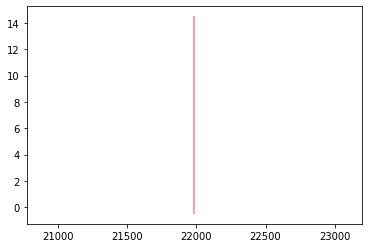

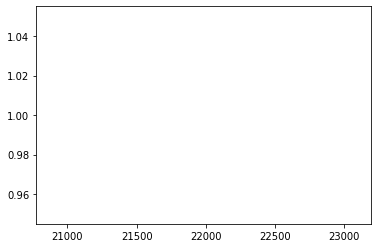

In [179]:
plt.plot(np.median(x), 1)

<BarContainer object of 20 artists>

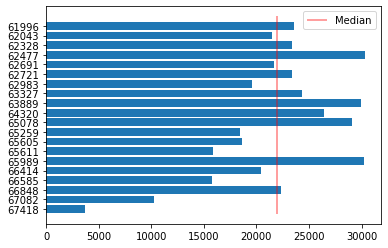

In [186]:
xticks = list(dct_unsuc.keys())
plt.vlines(np.median(x), ymin = -0.5, ymax = 20, color = 'r', label='Median', alpha = 0.5)
plt.legend(['Median'])
plt.barh(range(len(dct_unsuc)), x, tick_label = xticks)

In [187]:
x = []
for i in dct_unsuc:
    x.append(dct_unsuc.get(i).loc['likes'][1]['count'])

<BarContainer object of 20 artists>

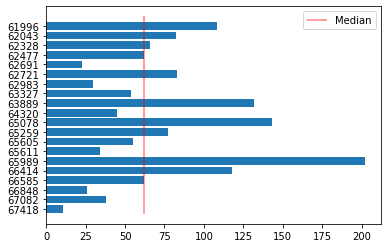

In [188]:
xticks = list(dct_unsuc.keys())
plt.vlines(np.median(x), ymin = -0.5, ymax = 20, color = 'r', label='Median', alpha = 0.5)
plt.legend(['Median'])
plt.barh(range(len(dct_unsuc)), x, tick_label = xticks)

In [190]:
x = []
for i in dct_unsuc:
    x.append(dct_unsuc.get(i).loc['views'][1]['count'])
y = []
for i in dct_unsuc:
    y.append(dct_unsuc.get(i).loc['likes'][1]['count'])


z = []
for i in range(len(x)):
    z.append(x[i]/y[i])

<BarContainer object of 20 artists>

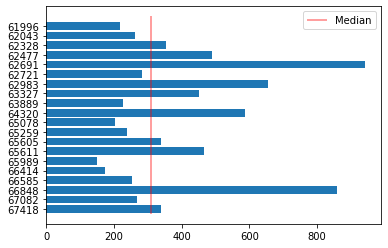

In [195]:
xticks = list(dct_unsuc.keys())
plt.vlines(np.median(z), ymin = -0.5, ymax = 20, color = 'r', label='Median', alpha = 0.5)
plt.legend(['Median'])
plt.barh(range(len(dct_unsuc)), z, tick_label = xticks)

In [81]:
test_test_test.loc['id']

1    67418
Name: id, dtype: object

In [38]:
response['response']['items'][0]['text']

'Я художник – я так… генерирую.\n\nЯндекс представил картинную галерею из 4 000 работ, созданных нейросетью. Более того, куратор выставки — тоже нейросеть! Похоже, искусство перестает быть привилегией людей.\n\nСоздатели ИИ-художника признались, что хотели разработать алгоритм, который умеет генерировать реалистичные лица. А живописи его обучили просто ради эксперимента. Но как раз здесь искусственный интеллект и нашел свое призвание.\n\nРаботы разбиты на четыре категории: «Люди», «Природа», «Город» и «Настроение». Кстати, любой желающий может выбрать одну любую картину и стать единственным владельцем оригинала. Это бесплатно: https://yandex.ru/lab/ganart\n\n#В_Закладки_Skillbox'

In [33]:
response['response']['items'][0]['likes']['count']

7

In [34]:
response['response']['items'][0]['comments']['count']

1

In [35]:
response['response']['items'][0]['reposts']['count']

1

In [200]:
corpus = []

In [201]:
for i in dct_unsuc:
    corpus.append(dct_unsuc.get(i).loc['text'][1])

In [222]:
import re

import pandas as pd
import pymorphy2


# разбиваем тест на слова
corpus = []
# регулярка для поиска слов
regular_expr = r'\w+'
reg_expr_compiled = re.compile(regular_expr)
# формируем датасет из отдельных слов
for raw_text in dct_unsuc:
    ## приводим к нижнему регистру
    raw_text_lower = dct_unsuc.get(raw_text).loc['text'][1].lower()
    # разбиваем текст на слова
    text_by_words = reg_expr_compiled.findall(raw_text_lower) 
    corpus.append(text_by_words)

# нормализация текста
normalized_corpus = []
morph = pymorphy2.MorphAnalyzer()
# нормализуем каждое слово в тексте
for token_list in corpus:
    normalized_token_list = []
    for word in token_list:
        parsed_token = morph.parse(word)
        normal_form = parsed_token[0].normal_form
        normalized_token_list.append(normal_form)
    normalized_corpus.append(normalized_token_list)

# превращаем в DataFrame
doc_count = len(normalized_corpus)
doc_ids = []
tokens = []
# формируем два списка-колонки датафрейма
for doc_id in range(doc_count):
    for token in normalized_corpus[doc_id]:
        doc_ids.append(doc_id)
        tokens.append(token)

tokens_df = pd.DataFrame({
    'doc_id': doc_ids,
    'word': tokens
})
# дамми-столбец
tokens_df = tokens_df.assign(dummy = 1)
# аггрегируем статистики
word_count_df = tokens_df.groupby(['doc_id','word'])['dummy'].count().reset_index()

word_count_df[word_count_df.doc_id==0].sort_values(by='dummy', ascending=False).head(10)
# На всякий
word_count_df['word'] = word_count_df['word'].apply(morph.parse)
word_count_df['word'] = [x[0].normal_form for x in word_count_df['word']]

In [223]:
word_count_df

,doc_id,word,dummy
0,0,000,1
1,0,4,1
2,0,ganart,1
3,0,https,1
4,0,lab,1
...,...,...,...
1435,19,столичный,1
1436,19,тайна,1
1437,19,фольклор,1
1438,19,экскурсия,1


In [224]:
pd.DataFrame(word_count_df.groupby('word')['dummy'].agg('count')).sort_values('dummy', ascending = False)

,dummy
word,
в,18
и,17
https,14
на,13
с,12
...,...
ковальский,1
когда,1
коллаж,1


In [225]:
def minus_pred(x):
    par = morph.parse(x)
    if par[0].tag.POS != ('NOUN' or 'VERB'):
        return
    return x   

In [226]:
word_count_df['word'] = word_count_df['word'].apply(minus_pred).dropna()

pd.DataFrame(word_count_df.groupby('word')['dummy'].agg('count')).sort_values('dummy', ascending = False)

In [231]:
###
dct_unsuc = {}
for offset in range(0, 1000, 20):
    url = 'https://api.vk.com/method/wall.get?access_token=' + str(acces_token) + f'&owner_id=-66669811&offset={offset}&count=20&v=5.92'
    response = getjson(url)
    for posts in response['response']['items']:
        test_test_test = pd.DataFrame(posts.items()).set_index(0)
        if test_test_test.loc['is_favorite'][1]:
            dct_suc[test_test_test.loc['id'][1]] = test_test_test
        else:
            dct_unsuc[test_test_test.loc['id'][1]] = test_test_test

In [233]:
x = []
for i in dct_unsuc:
    x.append(dct_unsuc.get(i).loc['views'][1]['count'])
y = []
for i in dct_unsuc:
    y.append(dct_unsuc.get(i).loc['likes'][1]['count'])
z = []
for i in range(len(x)):
    z.append(x[i]/y[i])

In [235]:
np.median(z)

238.53824200913243

In [240]:
indexes = []
for i in range(len(z)):
    if z[i] > np.median(z):
        indexes.append(i)

In [259]:
ids = []
for i in range(len(list(dct_unsuc.keys()))):
    if i in indexes:
        ids.append(list(dct_unsuc.keys())[i])

In [261]:
import re

import pandas as pd
import pymorphy2


# разбиваем тест на слова
corpus = []
# регулярка для поиска слов
regular_expr = r'\w+'
reg_expr_compiled = re.compile(regular_expr)
# формируем датасет из отдельных слов
for raw_text in ids:
    ## приводим к нижнему регистру
    raw_text_lower = dct_unsuc.get(raw_text).loc['text'][1].lower()
    # разбиваем текст на слова
    text_by_words = reg_expr_compiled.findall(raw_text_lower) 
    corpus.append(text_by_words)

# нормализация текста
normalized_corpus = []
morph = pymorphy2.MorphAnalyzer()
# нормализуем каждое слово в тексте
for token_list in corpus:
    normalized_token_list = []
    for word in token_list:
        parsed_token = morph.parse(word)
        normal_form = parsed_token[0].normal_form
        normalized_token_list.append(normal_form)
    normalized_corpus.append(normalized_token_list)

# превращаем в DataFrame
doc_count = len(normalized_corpus)
doc_ids = []
tokens = []
# формируем два списка-колонки датафрейма
for doc_id in range(doc_count):
    for token in normalized_corpus[doc_id]:
        doc_ids.append(doc_id)
        tokens.append(token)

tokens_df = pd.DataFrame({
    'doc_id': doc_ids,
    'word': tokens
})
# дамми-столбец
tokens_df = tokens_df.assign(dummy = 1)
# аггрегируем статистики
word_count_df = tokens_df.groupby(['doc_id','word'])['dummy'].count().reset_index()

word_count_df[word_count_df.doc_id==0].sort_values(by='dummy', ascending=False).head(10)
# На всякий
word_count_df['word'] = word_count_df['word'].apply(morph.parse)
word_count_df['word'] = [x[0].normal_form for x in word_count_df['word']]

In [262]:
word_count_df

,doc_id,word,dummy
0,0,000,1
1,0,4,1
2,0,ganart,1
3,0,https,1
4,0,lab,1
...,...,...,...
30605,499,участник,1
30606,499,финал,1
30607,499,хороший,1
30608,499,час,1


In [263]:
word_count_df['word'] = word_count_df['word'].apply(minus_pred).dropna()

suc_posts = pd.DataFrame(word_count_df.groupby('word')['dummy'].agg('count')).sort_values('dummy', ascending = False)

In [264]:
suc_posts

,dummy
word,
дизайн,126
работа,117
ссылка,105
проект,99
время,98
...,...
лёгкое,1
люканид,1
лэндинга,1


In [265]:
ids2 = []
for i in range(len(list(dct_unsuc.keys()))):
    if i not in indexes:
        ids2.append(list(dct_unsuc.keys())[i])

In [266]:
import re

import pandas as pd
import pymorphy2


# разбиваем тест на слова
corpus = []
# регулярка для поиска слов
regular_expr = r'\w+'
reg_expr_compiled = re.compile(regular_expr)
# формируем датасет из отдельных слов
for raw_text in ids2:
    ## приводим к нижнему регистру
    raw_text_lower = dct_unsuc.get(raw_text).loc['text'][1].lower()
    # разбиваем текст на слова
    text_by_words = reg_expr_compiled.findall(raw_text_lower) 
    corpus.append(text_by_words)

# нормализация текста
normalized_corpus = []
morph = pymorphy2.MorphAnalyzer()
# нормализуем каждое слово в тексте
for token_list in corpus:
    normalized_token_list = []
    for word in token_list:
        parsed_token = morph.parse(word)
        normal_form = parsed_token[0].normal_form
        normalized_token_list.append(normal_form)
    normalized_corpus.append(normalized_token_list)

# превращаем в DataFrame
doc_count = len(normalized_corpus)
doc_ids = []
tokens = []
# формируем два списка-колонки датафрейма
for doc_id in range(doc_count):
    for token in normalized_corpus[doc_id]:
        doc_ids.append(doc_id)
        tokens.append(token)

tokens_df = pd.DataFrame({
    'doc_id': doc_ids,
    'word': tokens
})
# дамми-столбец
tokens_df = tokens_df.assign(dummy = 1)
# аггрегируем статистики
word_count_df = tokens_df.groupby(['doc_id','word'])['dummy'].count().reset_index()

word_count_df[word_count_df.doc_id==0].sort_values(by='dummy', ascending=False).head(10)
# На всякий
word_count_df['word'] = word_count_df['word'].apply(morph.parse)
word_count_df['word'] = [x[0].normal_form for x in word_count_df['word']]

In [267]:
word_count_df['word'] = word_count_df['word'].apply(minus_pred).dropna()

unsuc_posts = pd.DataFrame(word_count_df.groupby('word')['dummy'].agg('count')).sort_values('dummy', ascending = False)

In [255]:
pd.DataFrame(word_count_df.groupby('word')['dummy'].agg('count')).sort_values('dummy', ascending = False).head(50)

,dummy
word,
skillbox_дизайн,131
работа,115
дизайнер,111
дизайн,95
статья,92
вебинар,78
проект,77
время,76
подборка,70


In [268]:
suc_posts

,dummy
word,
дизайн,126
работа,117
ссылка,105
проект,99
время,98
...,...
лёгкое,1
люканид,1
лэндинга,1


In [279]:
ras = []
for x in unsuc_posts.index:
    if x not in suc_posts.index:
        ras.append(x)

In [286]:
unsuc_posts.loc[ras][unsuc_posts['dummy'] > 4]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,dummy
word,
жанр,9
меню,7
шаблон,7
закладка,6
ход,6
поддержка,5
палитра,5
сочетание,5
чужое,5


In [283]:
dva = []
for x in suc_posts.index:
    if x not in unsuc_posts.index:
        dva.append(x)

In [285]:
suc_posts.loc[dva][suc_posts['dummy'] > 4]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,dummy
word,
лекторий,28
скидка,19
игра_skillbox_по_управление,17
ринг,14
зодиак,12
вампир,12
совместимость,12
битва,11
марафон,10


In [277]:
unsuc_posts

,dummy
word,
skillbox_дизайн,131
работа,115
дизайнер,111
дизайн,95
статья,92
...,...
затруднение,1
петербург,1
персонал,1
